### Measure PSI with current prod data and past dev
---

In [ ]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [ ]:
# load data

prev_df = pd.read_parquet(prev_test_df_path)
prev_df = mu.preprocess(prev_df)
prev_date = str(prev_df.sample_date.min()).split(" ")[0]

assert(len(prod_dfs_path)) == 1
for cur_date, pdf_path in prod_dfs_path.items():
    prod_df = pd.read_parquet(pdf_path)

In [ ]:
# load models
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

In [ ]:
# get all the snapshots
for mname, model in models.items(): 
    # set folder:
    mntr_path = os.path.join(artifact_path, "psi", f"psi_{mname}_{prev_date}-{cur_date}")
    os.makedirs(mntr_path, exist_ok=True)


    prev_df["model_pred"] = model.predict_proba(prev_df[model.feature_name_])[:,1]
    prev_df["model_score"] = mu.scale_scores(prev_df["model_pred"])

    # save plot
    fig = plt.figure()
    prod_df.model_score.hist(bins=10, alpha=0.4, density=True, label="production")
    prev_df.model_score.hist(bins=10, alpha=0.4, density=True, label="development")
    plt.legend()
    plt.show()
    fig.savefig(os.path.join(mntr_path, "score_psi.png"))
    
    # save psi df
    psi_df = mntr.get_psi(prev_df.model_score.to_frame(), 
                          prod_df.model_score.to_frame()).round(5)
    psi_df.to_csv(os.path.join(mntr_path, f"psi.csv"), index=False)
    display(psi_df)

### Monthly PSI
---

In [29]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [31]:
# load data

prev_df = pd.read_parquet(prev_test_df_path)
prev_df = mu.preprocess(prev_df)
prev_date = str(prev_df.sample_date.min()).split(" ")[0]

assert(len(prod_dfs_path)) == 1
for cur_date, pdf_path in prod_dfs_path.items():
    prod_df = pd.read_parquet(pdf_path)

In [32]:
# load models
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

In [33]:
# read data
df = pd.read_parquet(test_df_path)

In [34]:
prev_df.sample_date.unique()

array(['2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

  0%|          | 0/6 [00:05<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'model_score'

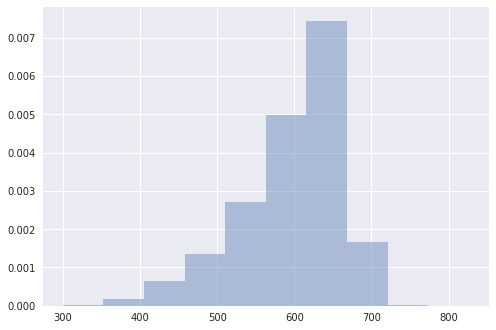

In [35]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        if mname != "incumbent_model":
            continue
        
        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "psi", f"psi_{mname}_{prev_date}-{dt_str}")
        os.makedirs(mntr_path, exist_ok=True)
        
        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        
        # preprocess data and get scores
        df_ = mu.prep_customer_data(df_)  # add is_active flag here
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])
        
        # plotting 
        df_.model_score.hist(bins=10, alpha=0.4, density=True, label=dt_str)
        prev_df.model_score.hist(bins=10, alpha=0.4, density=True, label="development")
        
        plt.legend()
        plt.show()
        fig.savefig(os.path.join(mntr_path, "score_psi.png"))
        
        # save psi df
        psi_df = mntr.get_psi(prev_df.model_score.to_frame(), 
                              df_.model_score.to_frame()).round(5)
        psi_df.to_csv(os.path.join(mntr_path, f"psi.csv"), index=False)
        display(psi_df)

### Additional Analysis, if required

In [ ]:
prev_df = pd.read_parquet(test_df_path)
prev_df = mu.preprocess(prev_df)
prev_date = "2021-01-01"

assert(len(prod_dfs_path)) == 1
for cur_date, pdf_path in prod_dfs_path.items():
    prod_df = pd.read_parquet(pdf_path)

In [ ]:
prev_df.shape

In [ ]:
# load models
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

In [ ]:
del models["incumbent_model"]  # we only want to look at customer_refitted_2021Q1 here

In [ ]:
mntr_path = os.path.join(artifact_path, "psi", f"psi_{mname}_{prev_date}-{cur_date}")
os.makedirs(mntr_path, exist_ok=True)


prev_df["model_pred"] = model.predict_proba(prev_df[model.feature_name_])[:,1]
prev_df["model_score"] = mu.scale_scores(prev_df["model_pred"])

# save plot
fig = plt.figure()
prod_df.model_score.hist(bins=10, alpha=0.4, density=True, label="production")
prev_df.model_score.hist(bins=10, alpha=0.4, density=True, label="development")
plt.legend()
plt.show()
fig.savefig(os.path.join(mntr_path, "score_psi.png"))

# save psi df
psi_df = mntr.get_psi(prev_df.model_score.to_frame(), 
                      prod_df.model_score.to_frame()).round(5)
psi_df.to_csv(os.path.join(mntr_path, f"psi.csv"), index=False)
psi_df